In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import scipy.interpolate
from scipy.ndimage import gaussian_filter
import tifffile
import seaborn as sns

from IPython.display import HTML
import matplotlib.animation as animation
from tqdm.notebook import tqdm, trange
from scipy.optimize import curve_fit
#import gaussian
from skimage.filters import gaussian
from scipy.interpolate import RectBivariateSpline
from PIL import Image
import itertools
from preprocessing import preprocessing_v2 as pp

import json

## PATHS and CONSTANTS



In [4]:
PROJECT_PATH = 'C:/Users/amityu/DataspellProjects/gel_sheets/'
DATA_PATH = 'C:/Users/amityu/Gel_Sheet_Data/'
#DATA_PATH = r'D:\amityu\backoffice_data\\'

movie = 'cca40'
ADD_PATH = os.path.join(PROJECT_PATH, "add_data/", movie + "/")


MOVIE_PATH = DATA_PATH +  movie + '/'
GRAPH_PATH = 'C:/Users/amityu/Gel_Sheet_Graph/'

In [9]:
execute = False
if execute:
    pp.save_exp_data(MOVIE_PATH, "75nM CA", 0.168,0.168,0.270,7,8)


## <span color=red >Load Images

</span>


In [7]:
#get list of files in directory
import os
filelist = os.listdir(MOVIE_PATH + 'tiff/C1/')
file_list_numbered = []
for i in range(len(filelist)):
    #split file by '_'
    t = int(filelist[i].split('_')[-2][1:])
    file_list_numbered.append((t,filelist[i]))
    #sort by time
file_list_numbered.sort(key = lambda x: x[0])
for t in range(len(file_list_numbered)):
    print(file_list_numbered[t][0],file_list_numbered[t][1])




1 cca40 arp40_1_T1_C1.tif
2 cca40 arp40 newaip 2min_T2_C1.tif
3 cca40 arp40 newaip 2min - 1_T3_C1.tif
4 cca40 arp40 newaip 2min - 1_T4_C1.tif
5 cca40 arp40 newaip 2min - 1_T5_C1.tif
6 cca40 arp40 newaip 2min - 1_T6_C1.tif
7 cca40 arp40 newaip 2min - 1_T7_C1.tif
8 cca40 arp40 newaip 2min - 1_T8_C1.tif
9 cca40 arp40 newaip 2min - 1_T9_C1.tif
10 cca40 arp40 newaip 2min - 2_T10_C1.tif
11 cca40 arp40 newaip 2min - 2_T11_C1.tif
12 cca40 arp40 newaip 2min - 2_T12_C1.tif
13 cca40 arp40 newaip 2min - 2_T13_C1.tif
14 cca40 arp40 newaip 2min - 2_T14_C1.tif
15 cca40 arp40 newaip 2min - 2_T15_C1.tif
16 cca40 arp40 newaip 2min - 2_T16_C1.tif
17 cca40 arp40 newaip 2min - 2_T17_C1.tif
18 cca40 arp40 newaip 2min - 3_T18_C1.tif
19 cca40 arp40 newaip 2min - 3_T19_C1.tif
20 cca40 arp40 newaip 2min - 3_T20_C1.tif
21 cca40 arp40 newaip 2min - 3_T21_C1.tif
22 cca40 arp40 newaip 2min - 3_T22_C1.tif
23 cca40 arp40 newaip 2min - 3_T23_C1.tif
24 cca40 arp40 newaip 2min - 3_T24_C1.tif
25 cca40 arp40 newaip 2min -

In [8]:
#load images
gel_list = []
for i in range(len(file_list_numbered)):
    gel_list.append(tifffile.imread(MOVIE_PATH + 'tiff/C1/' + file_list_numbered[i][1]).astype(np.float32))
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


In [9]:
# get the max z since images where taken with different
max_z = 0
for t, image in enumerate(gel_list):
    print(t,image.shape)
    z = image.shape[0]
    if z > max_z:
        max_z = z
print(max_z)


0 (79, 512, 512)
1 (79, 512, 512)
2 (79, 512, 512)
3 (79, 512, 512)
4 (79, 512, 512)
5 (79, 512, 512)
6 (79, 512, 512)
7 (79, 512, 512)
8 (79, 512, 512)
9 (108, 512, 512)
10 (108, 512, 512)
11 (108, 512, 512)
12 (108, 512, 512)
13 (108, 512, 512)
14 (108, 512, 512)
15 (108, 512, 512)
16 (108, 512, 512)
17 (108, 512, 512)
18 (108, 512, 512)
19 (108, 512, 512)
20 (108, 512, 512)
21 (108, 512, 512)
22 (108, 512, 512)
23 (108, 512, 512)
24 (108, 512, 512)
25 (108, 512, 512)
26 (108, 512, 512)
108


In [10]:
#set blank areas to nan
gel = np.zeros((len(gel_list), max_z,*gel_list[0].shape[1:]), dtype=np.float32)
gel[gel ==0] = np.nan
for t in range(len(gel)):
    gel[t,:gel_list[t].shape[0],:,:] = gel_list[t]

In [11]:
np.save(MOVIE_PATH + 'np/gel.npy',gel)

In [12]:
del gel

In [13]:
gel = np.load(MOVIE_PATH + 'np/gel.npy', mmap_mode='r')

## <span color=red > Load Channel 2 images

In [14]:
#get list of files in directory
import os
filelist = os.listdir(MOVIE_PATH + 'tiff\C2')
file_list_numbered = []
for i in range(len(filelist)):
    #split file by '_'
    t = int(filelist[i].split('_')[-2][1:])
    file_list_numbered.append((t,filelist[i]))
    #sort by time
file_list_numbered.sort(key = lambda x: x[0])
for t in range(len(file_list_numbered)):
    print(file_list_numbered[t][0],file_list_numbered[t][1])




1 cca40 arp40_1_T1_C2.tif
2 cca40 arp40 newaip 2min_T2_C2.tif
3 cca40 arp40 newaip 2min - 1_T3_C2.tif
4 cca40 arp40 newaip 2min - 1_T4_C2.tif
5 cca40 arp40 newaip 2min - 1_T5_C2.tif
6 cca40 arp40 newaip 2min - 1_T6_C2.tif
7 cca40 arp40 newaip 2min - 1_T7_C2.tif
8 cca40 arp40 newaip 2min - 1_T8_C2.tif
9 cca40 arp40 newaip 2min - 1_T9_C2.tif
10 cca40 arp40 newaip 2min - 2_T10_C2.tif
11 cca40 arp40 newaip 2min - 2_T11_C2.tif
12 cca40 arp40 newaip 2min - 2_T12_C2.tif
13 cca40 arp40 newaip 2min - 2_T13_C2.tif
14 cca40 arp40 newaip 2min - 2_T14_C2.tif
15 cca40 arp40 newaip 2min - 2_T15_C2.tif
16 cca40 arp40 newaip 2min - 2_T16_C2.tif
17 cca40 arp40 newaip 2min - 2_T17_C2.tif
18 cca40 arp40 newaip 2min - 3_T18_C2.tif
19 cca40 arp40 newaip 2min - 3_T19_C2.tif
20 cca40 arp40 newaip 2min - 3_T20_C2.tif
21 cca40 arp40 newaip 2min - 3_T21_C2.tif
22 cca40 arp40 newaip 2min - 3_T22_C2.tif
23 cca40 arp40 newaip 2min - 3_T23_C2.tif
24 cca40 arp40 newaip 2min - 3_T24_C2.tif
25 cca40 arp40 newaip 2min -

In [15]:
#load images
motors_list = []
for i in range(len(file_list_numbered)):
    motors_list.append(tifffile.imread(MOVIE_PATH + 'tiff/C2/' + file_list_numbered[i][1]))
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


In [16]:
# get the max z since images where taken with different
max_z = 0
for t, image in enumerate(motors_list):
    print(t,image.shape)
    z = image.shape[0]
    if z > max_z:
        max_z = z
print(max_z)


0 (79, 512, 512)
1 (79, 512, 512)
2 (79, 512, 512)
3 (79, 512, 512)
4 (79, 512, 512)
5 (79, 512, 512)
6 (79, 512, 512)
7 (79, 512, 512)
8 (79, 512, 512)
9 (108, 512, 512)
10 (108, 512, 512)
11 (108, 512, 512)
12 (108, 512, 512)
13 (108, 512, 512)
14 (108, 512, 512)
15 (108, 512, 512)
16 (108, 512, 512)
17 (108, 512, 512)
18 (108, 512, 512)
19 (108, 512, 512)
20 (108, 512, 512)
21 (108, 512, 512)
22 (108, 512, 512)
23 (108, 512, 512)
24 (108, 512, 512)
25 (108, 512, 512)
26 (108, 512, 512)
108


In [17]:
#set blank areas to nan
motors = np.zeros((len(motors_list), max_z,*motors_list[0].shape[1:]))
motors[motors ==0] = np.nan
#for new_gel_index, gel_index in enumerate(np.concatenate((range(12), range(13,38)))):

for t in range(len(motors)):

    motors[t,:motors_list[t].shape[0],:,:] = motors_list[t]

In [19]:
np.save(MOVIE_PATH + 'np/channel2.npy',motors)

## <span color = red> transform gel

In [22]:
    #import gaussian filter
#manually  add directory tmp, in experiment locataion  "cca40/tmp/ and in project location 'add_data/cca40/transform'

from scipy.ndimage import gaussian_filter
gel = np.load(MOVIE_PATH + 'np/gel.npy', mmap_mode='r')
#for t in range(len(gel)):
#    gel[t] = gaussian_filter(gel[t],2)
img = pre.stabilize(gel[:,:80,:,:], movie_path=MOVIE_PATH ,transform_path =PROJECT_PATH + 'add_data/%s/transform/'%movie, mask_coordinates = (10,22,0,512,0,512),  moving_mask_coordinates =(10,22, 0,512,0,512),  transformation_type='DenseRigid')


2024-04-25 11:45:28


100%|██████████| 27/27 [05:33<00:00, 12.35s/it]


### applyting calculated transform to gel


In [23]:
gel = np.load(MOVIE_PATH + 'np/gel.npy', mmap_mode='r')
gel_transformed = np.zeros(gel.shape, dtype = np.float32)
import ants
for t in trange(len(gel)):
    numpy_image = np.array(np.transpose(gel[t], (2,1,0)))
    image = ants.from_numpy(numpy_image)

    


    new_image = ants.apply_transforms(fixed=image, moving=image, transformlist=PROJECT_PATH + 'add_data/%s/transform/transform%d.mat'%(movie,t+1), defaultvalue =0)
    gel_transformed[t] = np.transpose(new_image.numpy(), (2,1,0))
    

  0%|          | 0/27 [00:00<?, ?it/s]

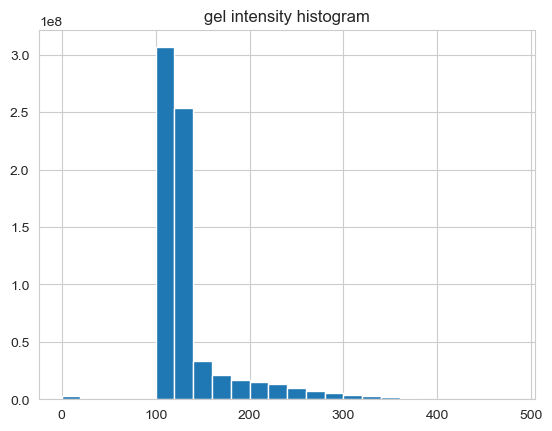

In [26]:
plt.hist(gel_transformed[~np.isnan(gel_transformed)], bins = np.arange(0,500,20))
plt.title('gel intensity histogram')
plt.show()


In [24]:
np.save(MOVIE_PATH + 'np/gel_transformed.npy',gel_transformed)

In [28]:
channel2 = np.load(MOVIE_PATH + 'np/channel2.npy')
channel2_transformed = np.zeros(channel2.shape)
import ants
for t in range(len(channel2)):
    image = ants.from_numpy(np.transpose(channel2[t], (2,1,0)))
    new_image = ants.apply_transforms(fixed=image, moving=image, transformlist=PROJECT_PATH + 'add_data/%s/transform/transform%d.mat'%(movie,t+1), defaultvalue =0)
    channel2_transformed[t] = np.transpose(new_image.numpy(), (2,1,0))

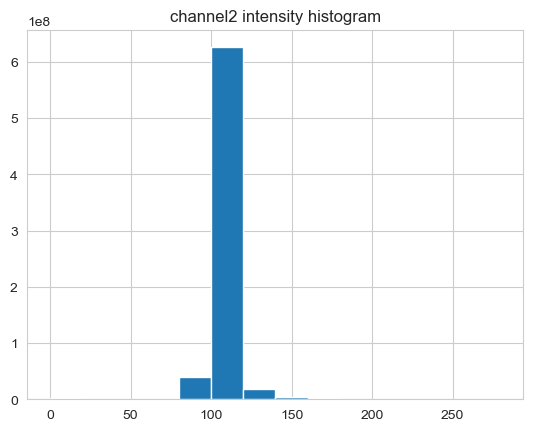

In [30]:
plt.hist(channel2_transformed[~np.isnan(channel2_transformed)], bins = np.arange(0,300,20))
plt.title('channel2 intensity histogram')
plt.show()


In [32]:
np.save(MOVIE_PATH + 'np/channel2_transformed.npy',channel2_transformed)

In [35]:
del gel_transformed, gel_corrected, gel_corrected_tmp

## <span color=red >LOAD RAW GEL HERE


In [77]:
gel_transformed = np.load(MOVIE_PATH + 'np/gel_transformed.npy')

gel_transformed[np.isnan(gel_transformed)] = np.nanmean(gel_transformed[25,70:80,:,:])

## <span color=red> Illumination filter

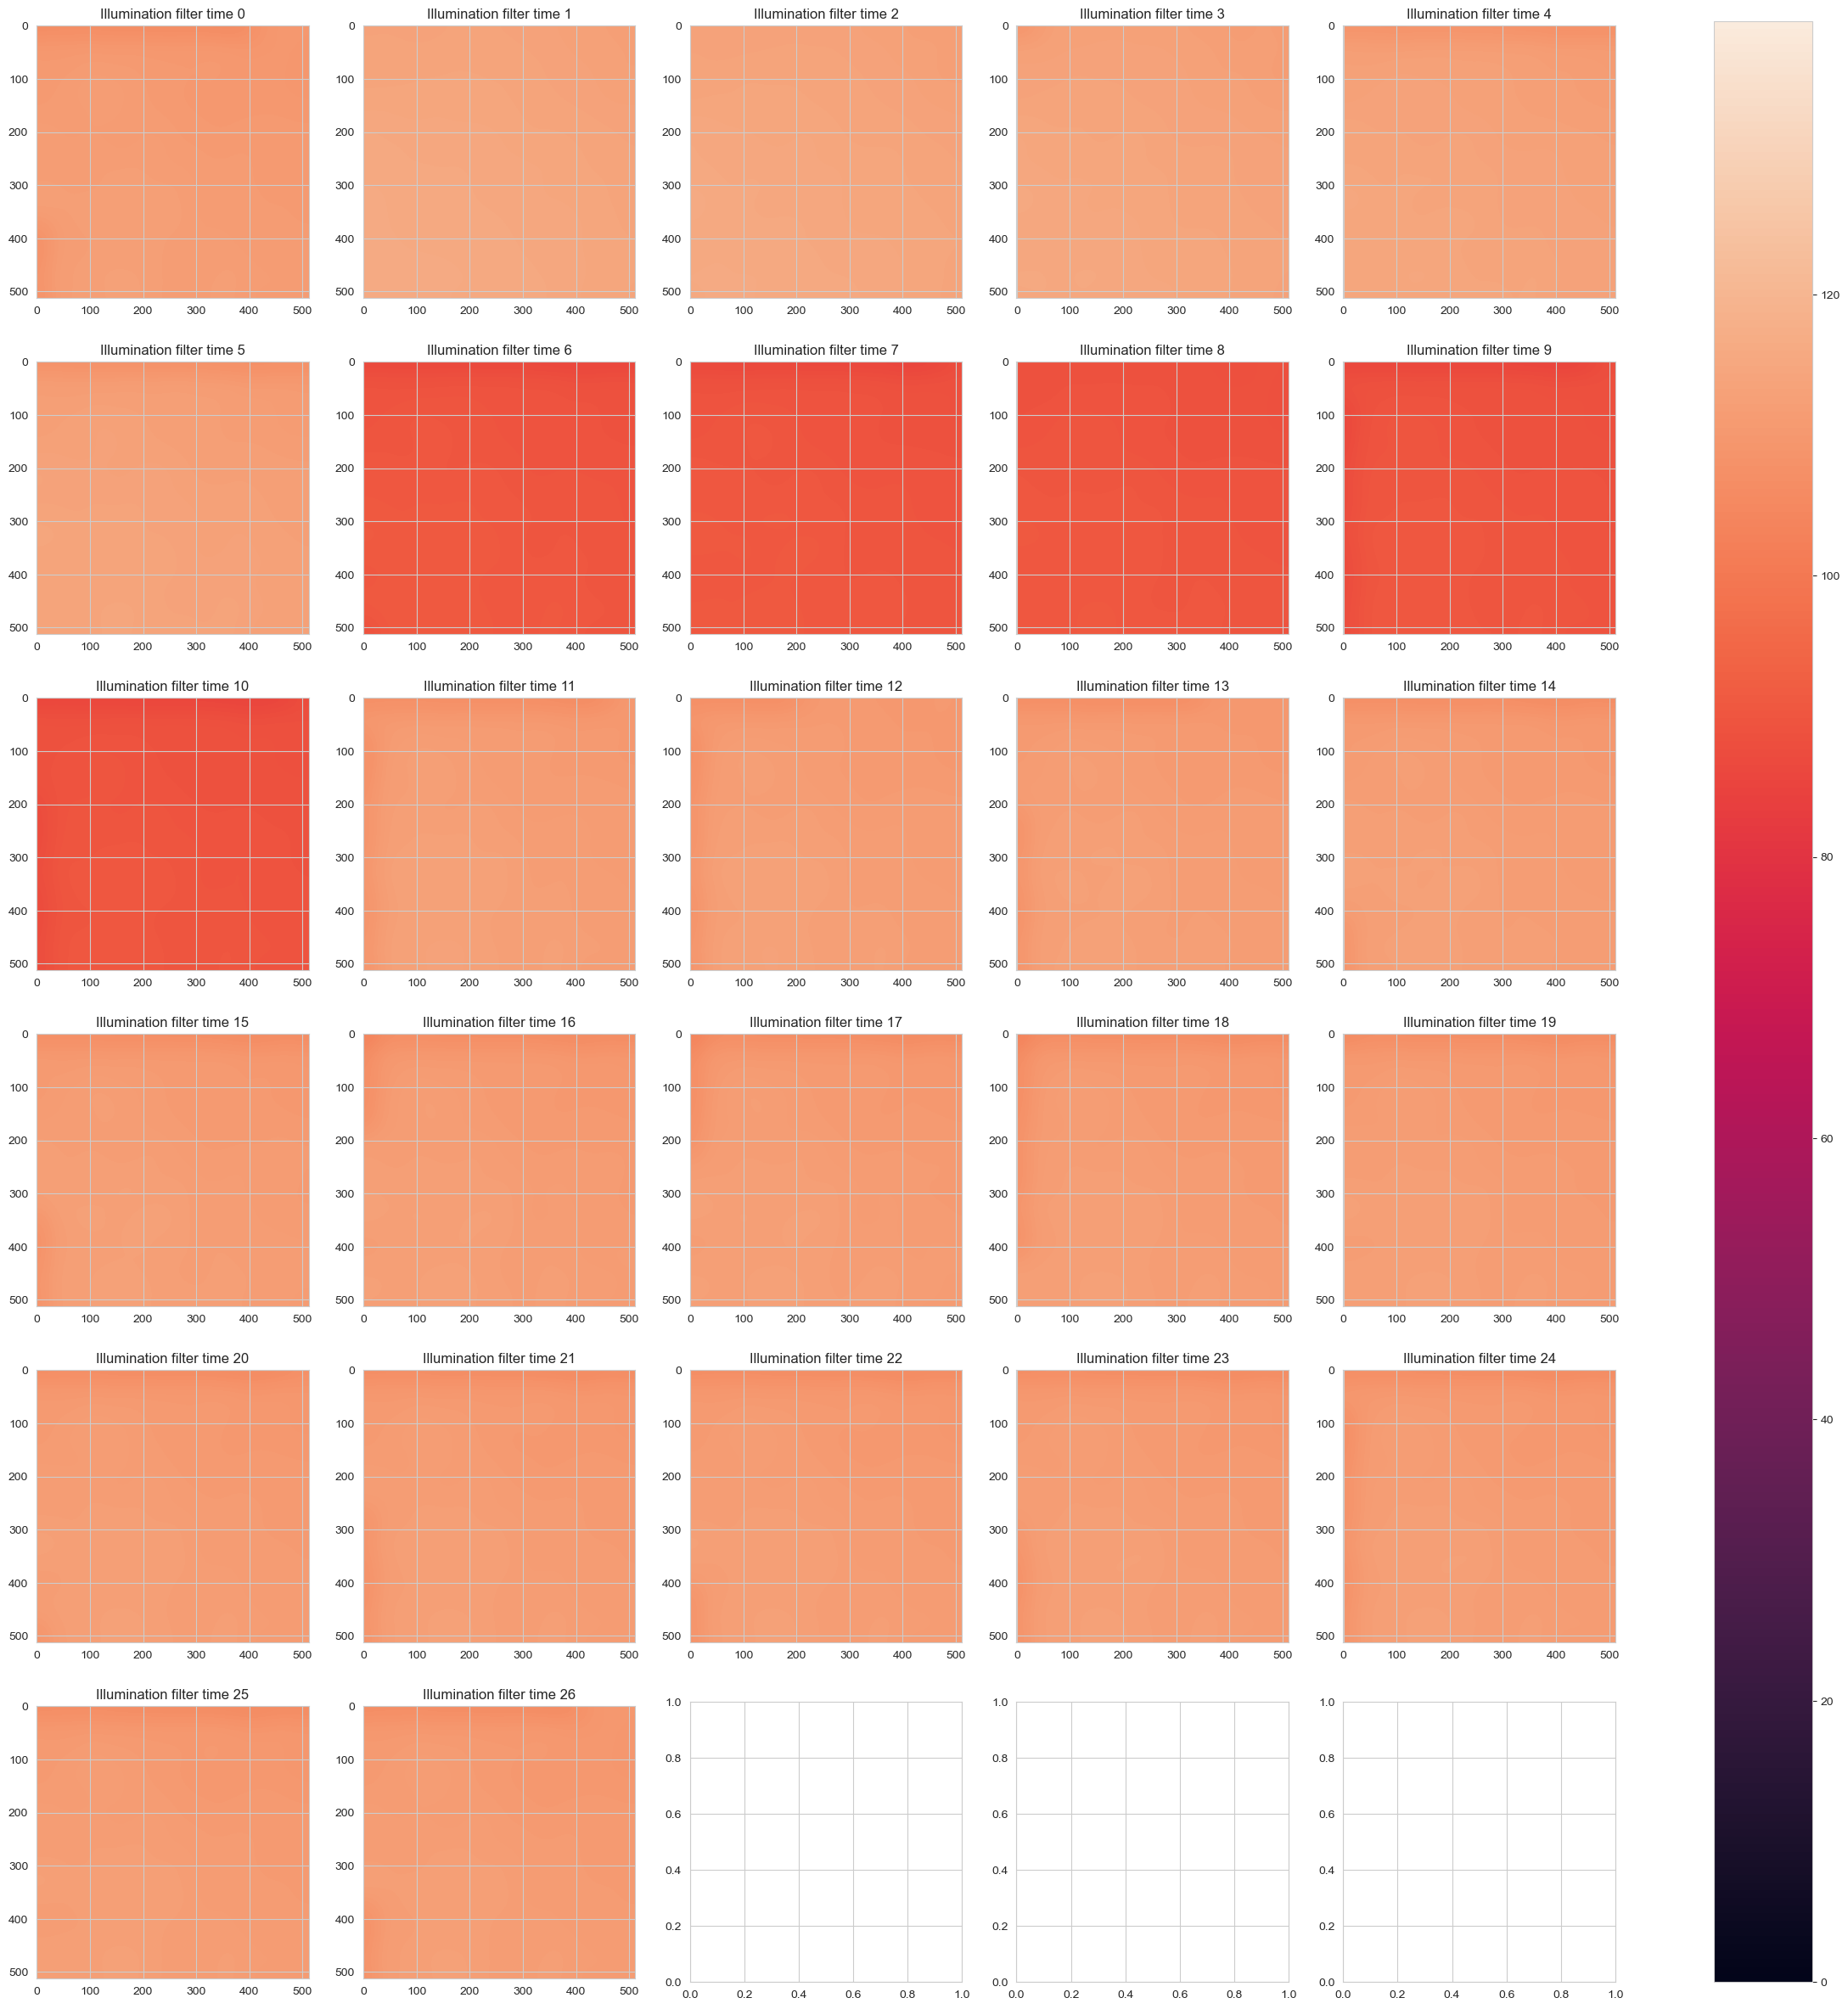

In [78]:
fig, axes = plt.subplots(6,5, figsize = (30,30))
vmin = np.nanmin(gel_transformed[:,0:5,:,:])
vmax = np.nanmax(gel_transformed[:,0:5,:,:])
axes = axes.ravel()
for i,t in enumerate(range(0,len(gel_transformed))):
    slice = gel_transformed[t,0:5,:,:]
    slice[np.isnan(slice)] = np.nanmean(slice)
    illumination_filter = np.nanmean(gaussian_filter(slice,sigma=25),axis = 0)
    axes[i].imshow(illumination_filter, vmin=vmin, vmax=vmax)
    axes[i].set_title('Illumination filter time %d'%t)

fig.colorbar(axes[0].imshow(illumination_filter, vmin=vmin, vmax=vmax), ax=axes.ravel().tolist())    
plt.show()

In [79]:
# Shifthing all intensity values by the distance between the slice mean value of each frame to the slice mean value of frame zero to compensate for illumination jumps

mean_zero = np.nanmean(gel_transformed[0,0:5,:,:])

for t in trange(len(gel_transformed)):
    slice = gel_transformed[t,0:5,:,:]
    
    #slice[np.isnan(slice)] = np.nanmean(slice)
   
    gel_transformed[t] = gel_transformed[t] - (np.nanmean(slice) - mean_zero) 

  0%|          | 0/27 [00:00<?, ?it/s]

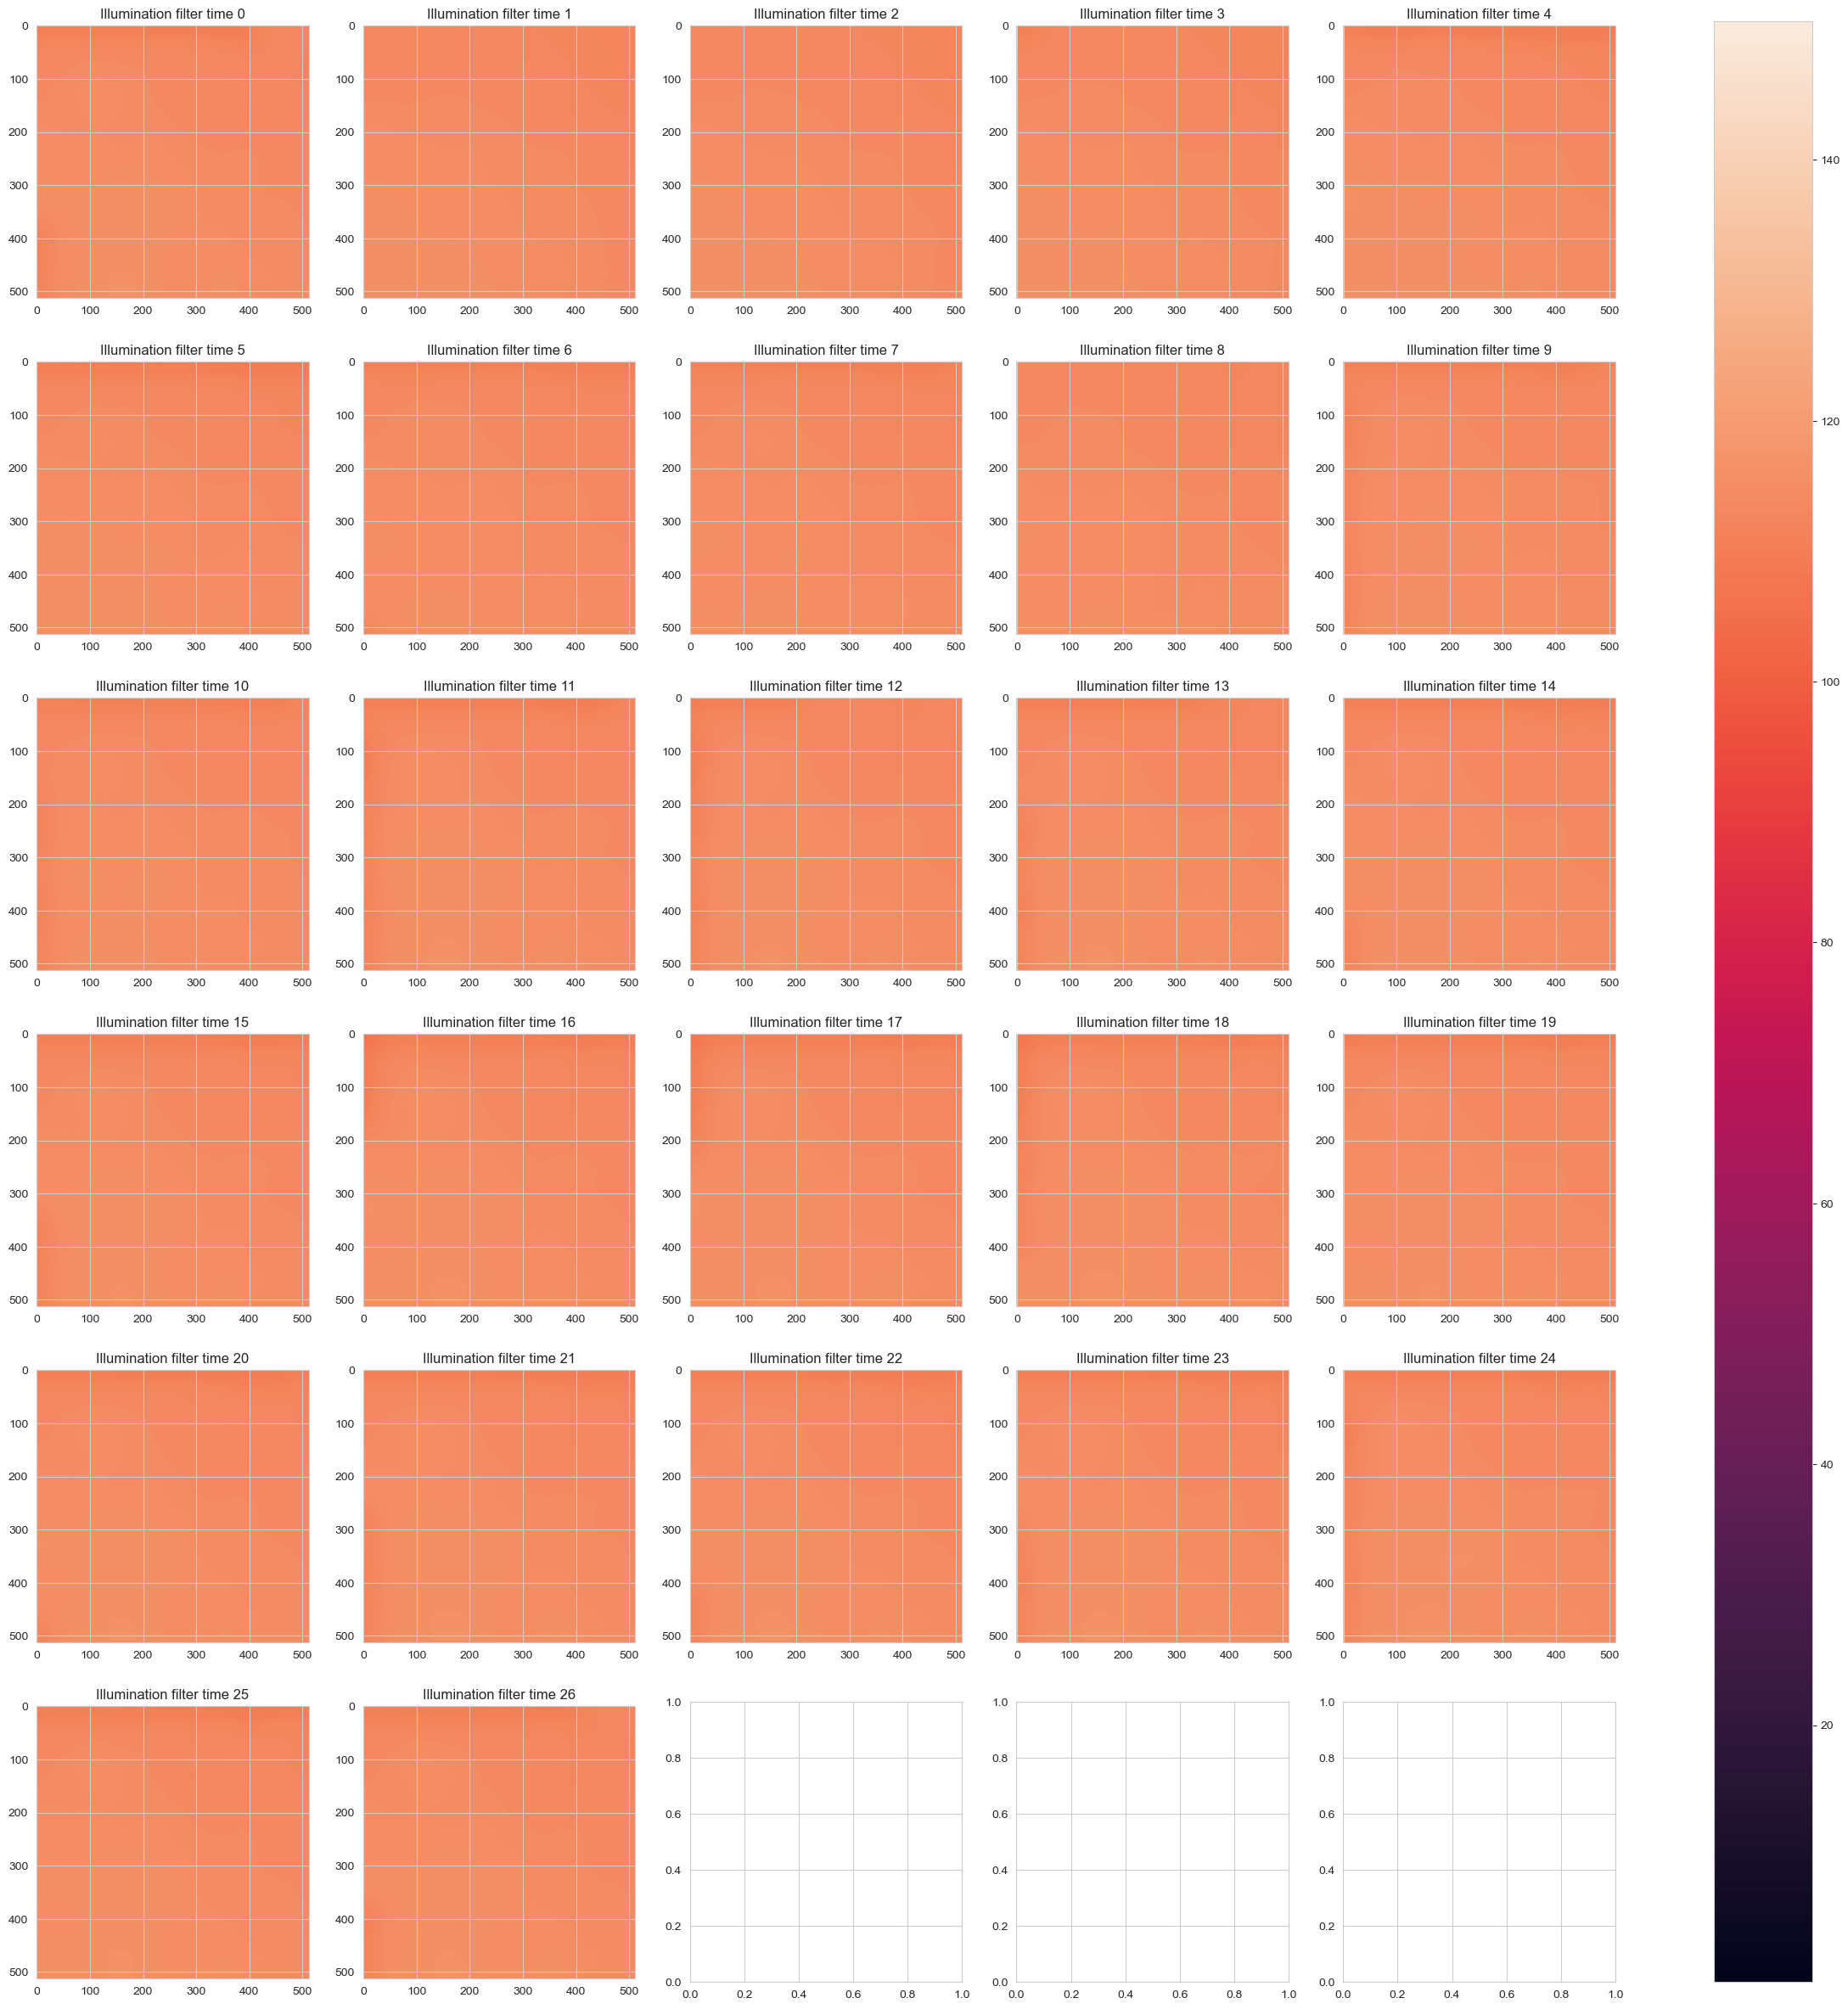

In [82]:
#check again illumination
fig, axes = plt.subplots(6,5, figsize = (30,30))
vmin = np.nanmin(gel_transformed[:,0:5,:,:])
vmax = np.nanmax(gel_transformed[:,0:5,:,:])
axes = axes.ravel()
for i,t in enumerate(range(0,len(gel_transformed))):
    slice = gel_transformed[t,0:5,:,:]
    slice[np.isnan(slice)] = np.nanmean(slice)
    illumination_filter = np.nanmean(gaussian_filter(slice,sigma=25),axis = 0)
    axes[i].imshow(illumination_filter, vmin=vmin, vmax=vmax)
    axes[i].set_title('Illumination filter time %d'%t)

fig.colorbar(axes[0].imshow(illumination_filter, vmin=vmin, vmax=vmax), ax=axes.ravel().tolist())
plt.show()

In [83]:
gel_corrected = np.zeros(gel_transformed.shape, dtype=np.float32)
filter_sigma = 25

for t in trange(len(gel_transformed)):
    slice = gel_transformed[t,0:5,:,:]
    slice[np.isnan(slice)] = np.nanmean(slice)
    illumination_filter = np.nanmean(gaussian_filter(slice,sigma=25),axis = 0)
    gel_corrected[t] = gel_transformed[t]/illumination_filter

  0%|          | 0/27 [00:00<?, ?it/s]

In [40]:
del gel_transformed

In [85]:
np.nonzero(gel_corrected[gel_corrected<0.02])[0].sum()

5592324403

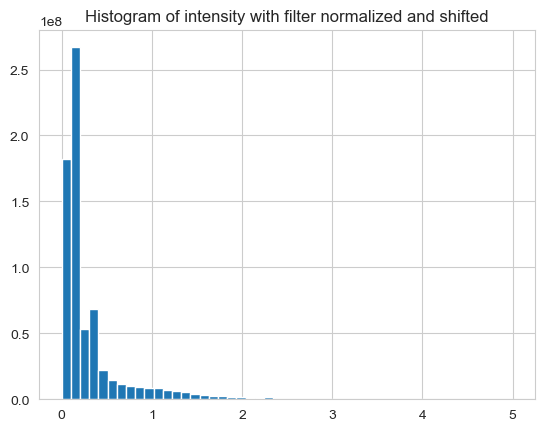

In [100]:

from utils import graph_utils as gu
gel_corrected_tmp = gel_corrected.copy()
gel_corrected_tmp[gel_corrected_tmp==0]=np.nan
#value of minimum range should be between 0.2-0.5 so that all values start with zeros
gel_corrected_tmp = gu.percentile_normalize(gel_corrected_tmp, 0.5,99.8)
bins = np.linspace(0, 5, 50)
plt.hist(gel_corrected_tmp[~np.isnan(gel_corrected_tmp)], bins = bins)
plt.title('Histogram of intensity with filter normalized and shifted')
plt.show()

In [101]:
np.save(MOVIE_PATH + 'np/gel_norm.npy',gel_corrected_tmp)

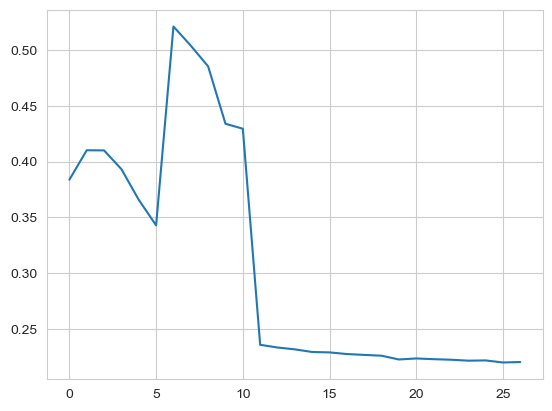

In [104]:
plt.plot(np.nanmean(gel_corrected_tmp, axis = (1,2,3)))

In [12]:
gel_corrected = np.load(MOVIE_PATH + 'np/gel_norm.npy')

<span color = yellow> Background bellow membrane measuring


###    Illumination filter validation

###    Illumination filter animation


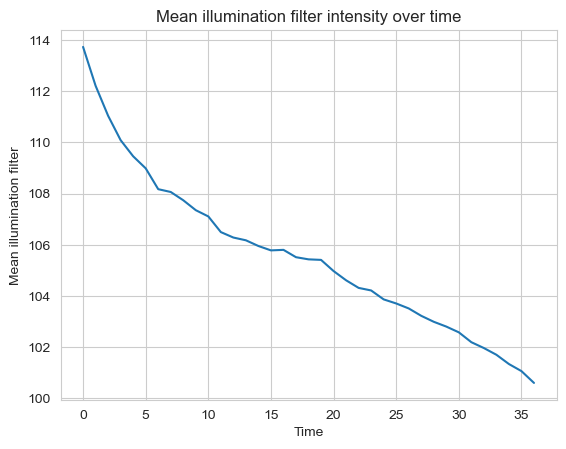

In [49]:
mean_illumination = np.mean(frames, axis = (1,2))
plt.plot(mean_illumination)
plt.title('Mean illumination filter intensity over time')
plt.xlabel('Time')
plt.ylabel('Mean illumination filter')
plt.show()


### geting monomoer signal,
## finding monomer area
## Line scan of monomer area animation

In [49]:
from IPython.display import HTML
plt.rcParams['animation.html'] = 'jshtml'
import matplotlib.animation as animation
gel = np.load(MOVIE_PATH + 'np/gel_norm.npy')
mip_width = 20
frame_shape = gel[0,:,:,0].shape
max_intensity = 10#np.nanmax(gel)
num_frames = len(gel)
j = 256
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

# Update function for each frame
def update_frame(t):

    ax.clear()
    for i in range(0,500,mip_width*3):
    #for i in range(0,gel.shape[2],mip_width):

        line = np.max(gel[t,:,i:i+mip_width,j:j+mip_width], axis=(1,2)) #get line of intensity
        #replace nun with zero in image
        line[np.isnan(line)] = 0
        plot = ax.plot(line, label = 'i = %d - %d'%(i, i+mip_width))
        ax.set_ylim (0,max_intensity)
        plt.xlabel('Z')
        plt.ylabel('Intensity')

    ax.set_title('movie %s Frame: %d j=%d, mip_width=%d' % (movie,t,j,mip_width))
    ax.legend()
    return plot

# Create the animation
myanimation = animation.FuncAnimation(fig, update_frame, range(num_frames), interval=1000, blit=True)
writer = animation.FFMpegWriter(fps=1)

myanimation.save(GRAPH_PATH + 'preprocessing/' + movie + 'linescan_j=%d_mip_width=%d.mp4'%(j,mip_width), writer=writer)

# Display the animation
#plt.show()
#HTML(myanimation.to_jshtml())
plt.close()

## <span color = red>RAW MIP  animation

## <span color = red>Gel monomer free area animation <span>


# now we treat gel as the final version after illumination filter and transformation


In [50]:
from scipy.optimize import curve_fit

# Define the Gaussian function
def fit_gaussian(x, mu, sigma, amplitude):
    return amplitude * np.exp(-0.5 * ((x - mu) / sigma) ** 2)


In [51]:
def plot_data(data, bins, bins_number=50):
    # bins = np.linspace(min_intensity, max_intensity, bins_number+1)   # Define the bins
    hist, _ = np.histogram(data[~np.isnan(data)], bins=bins, density=True)
    mean = np.nanmean(data)
    std = np.nanstd(data)

    # Calculate the bin widths
    bin_widths = bins[1:] - bins[:-1]
    bin_gap_mid = (bins[1] - bins[0])/ 2
    # Calculate the density function
    density = hist / np.sum(hist * bin_widths)
    #original_array = density

    x_data = np.linspace(bins[0] + bin_gap_mid , bins[-1] - bin_gap_mid, len(density))
    y_data = density

    # Fit the Gaussian function to the data
    initial_guess = [mean, std, 1]  # Initial guess for the parameters: [mu, sigma, amplitude]
    optimized_params, _ = curve_fit(fit_gaussian, x_data, y_data, p0=initial_guess)

    # Extract the optimized parameter values
    mu_opt, sigma_opt, amplitude_opt = optimized_params

    # Generate the fitted curve using the optimized parameters
    y_fitted = fit_gaussian(x_data, mu_opt, sigma_opt, amplitude_opt)
    new_indices = np.linspace(0, len(y_fitted) - 1, 50 * len(y_fitted))

    # Perform interpolation
    interpolated_y   = np.interp(new_indices, range(len(y_fitted)), y_fitted)
    interpolated_x   = np.interp(new_indices, range(len(y_fitted)), x_data)
    smoothed_y = gaussian_filter(interpolated_y, sigma=15)
    return interpolated_x, smoothed_y, density,  mu_opt, sigma_opt, amplitude_opt

In [67]:
gel = np.load(MOVIE_PATH + 'np/gel_norm.npy')

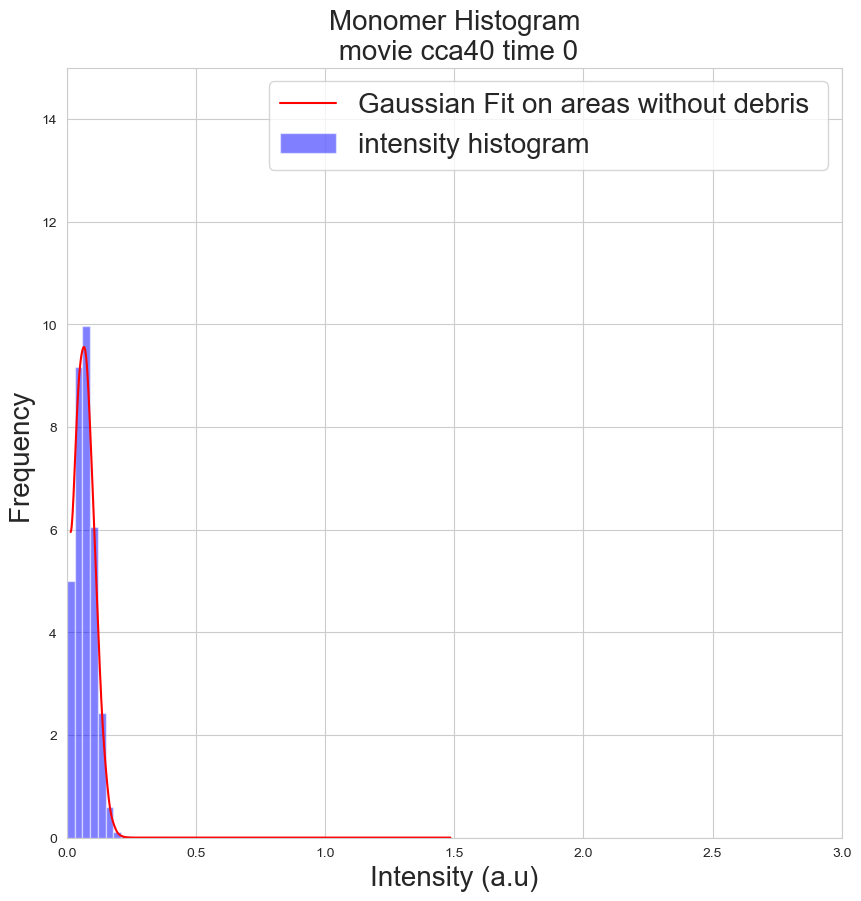

In [105]:
#put monomer react in add path
illumination_fix = True
monomer_data_df = pd.read_csv(ADD_PATH + 'monomer_rect.csv')
#monomer_data_df = pd.read_csv(MOVIE_PATH + 'np/rec_tmp.csv')
sigma = 25
z = 0
delta_z = 5
bin_number = 50
frame_shape = gel[0,:,:,0].shape
num_frames = len(gel)
y_max = 15
#gel_corrected = np.zeros(gel.shape)
#gel_corrected[np.isnan(gel_corrected)] = 0
#for t in range(len(gel)):
#    gel_corrected[t] = gel[t] / illumination_filter
#gel_corrected[gel_corrected < 0.5] = np.nan
max_intensity = np.nanmax(gel)
max_intensity =1.5
min_intensity = np.nanmin(gel)


bin_number = 50
bins = np.linspace(min_intensity, max_intensity, bin_number + 1)
I_mean_list = []
I_std_list = []

# Update function for each frame
def update_frame(t):
    ax.clear()

    iz = monomer_data_df.at[t, 'Z']
    iy =monomer_data_df.at[t, 'Y']
    ix = monomer_data_df.at[t, 'X']
    r_size = monomer_data_df.at[t, 'r_size']
    gap_from_surface =monomer_data_df.at[t, 'gap_from_surface']
    y_gap = monomer_data_df.at[t, 'y_gap']
    data_corrected = gel[t, iz+gap_from_surface:iz+r_size, iy:iy+y_gap, ix:ix+r_size]
    #data_not_corrected = gel_corrected[t, iz+gap_from_surface:iz+r_size, iy:iy+y_gap, :]

    data_corrected = data_corrected[~np.isnan(data_corrected)]
    if data_corrected.size == 0:
        return plot,
    #data_not_corrected = data_not_corrected[~np.isnan(data_not_corrected)]
    #if data_not_corrected.size == 0:
    #    return plot,

    # Create an array for the interpolated values
    try:
        interpolated_x, smoothed_y, density, mean, std, amp = plot_data(data_corrected, bins=bins)

        I_mean_list.append(mean)
        I_std_list.append(std)
        ax.set_xlabel('Intensity (a.u)', fontsize = 20)
        ax.set_ylabel('Frequency ', fontsize = 20)
        ax.set_ylim(0, y_max)
        ax.set_xlim(0,3)
        #ax.set_title('Monomer Histogram\n movie %s time %d \n z=%d-%d, x=%d-%d all y \n ' % (movie, t, row['z_start'], row['z_start'] + row['z_gap'], row['j_start'], row['j_start'] + row['j_gap']))
        ax.set_title('Monomer Histogram\n movie %s time %d' % (movie, t ), fontsize = 20)

        #interpolated_x, smoothed_y, density, mean, std, amp = plot_data(data_not_corrected, bins=bins)
        #ax.plot(interpolated_x, smoothed_y, color='b', label='Gaussian Fit on all values including debris ')
        ax.plot(interpolated_x, smoothed_y, color='r', label='Gaussian Fit on areas without debris ')
    except:
        print(t, 'error')
        return plot,
    #density[np.isnan(density)] = 0
    ax.bar(bins[:-1], density, width=np.diff(bins), align='edge', label='intensity histogram', alpha=0.5, color='b')
    ax.legend(fontsize = 20)
    plt.savefig(GRAPH_PATH + 'detecting_monomer/{}_tmp'.format(movie))
    return plot,


# Create a figure and axis
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
#ax.set_position([0.1, 0.1, 0.8, 0.8])  # Sets the size of the axes within the figure

# Create an empty plot
plot = ax.bar(bins, np.ones(len(bins)))


# Create the animation
myanimation = animation.FuncAnimation(fig, update_frame, range(len(gel)), interval=1000)
writer = animation.FFMpegWriter(fps=1)

myanimation.save(GRAPH_PATH + 'detecting_monomer\%s_monomer_hist_red_clean.mp4' % movie, writer=writer)

# Display the animation
HTML(myanimation.to_jshtml())
#plt.close()

In [106]:
I_mean_list = []
I_std_list = []
z = 0
delta_z = 5
sigma = 25


max_intensity =1.5
min_intensity = np.nanmin(gel)


bin_number = 50
bins = np.linspace(min_intensity, max_intensity, bin_number + 1)


for t in trange(len(gel)):

    iz = monomer_data_df.at[t, 'Z']
    iy =monomer_data_df.at[t, 'Y']
    ix = monomer_data_df.at[t, 'X']
    r_size = monomer_data_df.at[t, 'r_size']
    gap_from_surface =monomer_data_df.at[t, 'gap_from_surface']
    y_gap = monomer_data_df.at[t, 'y_gap']
    data_corrected = gel[t, iz+gap_from_surface:iz+r_size, iy:iy+y_gap, ix:ix+r_size]

    data_corrected = data_corrected[~np.isnan(data_corrected)]
    if data_corrected.size == 0:
        I_mean_list.append(np.nan)
        I_std_list.append(np.nan)
        continue
    interpolated_x, smoothed_y, density, mean, std, amp = plot_data(data_corrected, bins=bins)
    I_mean_list.append(mean)
    I_std_list.append(std)



monomer_data_df['gaussian_mean'] = I_mean_list
monomer_data_df['gaussian_std'] = I_std_list
monomer_data_df.to_csv(MOVIE_PATH + 'np/monomer_rectv2.csv')

  0%|          | 0/27 [00:00<?, ?it/s]

### <span color = red> copy dataframe to add data folder


In [107]:
monomer_data_df = pd.read_csv(ADD_PATH + 'monomer_rect.csv')

In [108]:
#reload pre
import importlib
importlib.reload(pre)


<module 'preprocessing.preprocessingV2' from 'C:\\Users\\amityu\\DataspellProjects\\gel_sheets\\preprocessing\\preprocessingV2.py'>

In [5]:
gel = np.load(MOVIE_PATH + 'np/gel_norm.npy')

In [9]:
data = gel[~np.isnan(gel)]

In [14]:
np.min(data), np.max(data)

(0.0, 2.333618)

In [15]:
from utils import analysis_utils as au
hist, bin_edegs = au.histogram_cupy(data, bins = 50)

<BarContainer object of 50 artists>

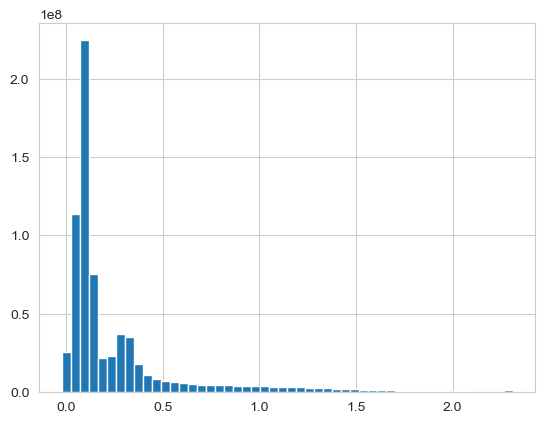

In [21]:
plt.bar(bin_edegs[:-1], hist, width=(bin_edegs[1] - bin_edegs[0]))

In [114]:
from skimage.filters import apply_hysteresis_threshold
from skimage import morphology
from skimage.morphology import ball
from scipy.ndimage import label
from preprocessing import preprocessingV2 as pre
surface, membrane = pre.get_surface_and_membrane(gel, ADD_PATH, number_of_std=4.5)

100%|██████████| 27/27 [00:30<00:00,  1.13s/it]


In [115]:
np.save(MOVIE_PATH + 'np/height.npy', surface)    
np.save(MOVIE_PATH + 'np/membrane.npy',membrane)

In [5]:
from preprocessing import preprocessingV2 as pre
surface = np.load(MOVIE_PATH + 'np/height.npy')
spike = pre.spike(surface)


In [6]:
np.save(MOVIE_PATH + 'np/spike.npy', spike)